In [ ]:
import numpy as np                                     
from numpy.linalg import matrix_power                  
import matplotlib.pyplot as plt                                                        
from iminuit import Minuit                            
import sys                                            
from scipy import stats
from scipy.integrate import quad
import sympy as sp
from sympy import integrate , print_latex
import pandas as pd
from IPython.display import display

#### Data generator functions:

In [253]:
#generate data from a poisson distribution
def poisson_data(Lambda,N):
    '''Function for generating data from a poisson distribution
    
       N: number of events
       mu: mean of distribution
       
       returns: array of data'''
    data = np.random.poisson(Lambda, N)
    return data



#generate data from a gaussian distribution
def gaussian_data(mu, sigma, N):
    '''Function for generating data from a gaussian distribution
    
       N: number of events
       mu: mean of distribution
       sigma: standard deviation of distribution
       
       returns: array of data'''
    data = np.random.normal(mu, sigma, N)
    return data


#generate data from a binomial distribution
def binomial_data(n, p, N):
    '''Function for generating data from a binomial distribution
    
       N: number of events
       p: probability of success
       
       returns: array of data'''
    data = np.random.binomial(n, p, N)
    return data

#### binning / histogram function: 

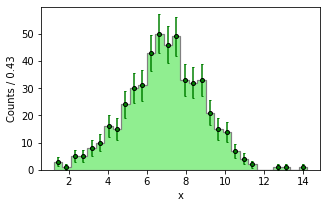

In [260]:
#Binning function

import numpy as np
def binning(x, xrange, Nbins, remove_empty=True):
    '''Function for binning data and removing empty bins
    
       x: data to be binned
       xrange: range of data in tuble (min, max)
       Nbins: number of bins
       remove_empty_bins: if True, empty bins are removed from
       
       returns: counts, bin_centers, binwidth'''
    binwidth = (xrange[1]-xrange[0])/Nbins
    counts , bin_edges = np.histogram(x, range=xrange, bins=Nbins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

    if remove_empty:
        bin_centers = bin_centers[counts>0]
        counts = counts[counts>0]

    return counts , bin_centers, binwidth
    


#Plotting histogram:

def easy_hist(x, Nbins, Figsize=(10, 7)):
    '''Function for plotting a histogram
    
       x: data to be binned
       xrange: range of data in tuble (min, max)
       Nbins: number of bins
       '''
    
    counts, bin_centers, binwidth = binning(x, (min(x),max(x)), Nbins)
    fig, ax = plt.subplots(figsize=Figsize)
    ax.hist(x, bins=Nbins ,range=(min(x),max(x)), histtype='stepfilled', color='lightgreen', edgecolor='grey', linewidth=1.2)
    ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o',ms=4,mec='k',mfc='g', capsize=1, ecolor='g')
    ax.set(xlabel='x', ylabel=f'Counts / {binwidth:.2f}')
    plt.show()
    
    return fig, ax , counts



#example:
x1 = gaussian_data(7, 2,500)
easy_hist(x1, 30,Figsize=(5, 3));



#### Monte Carlo functions: 

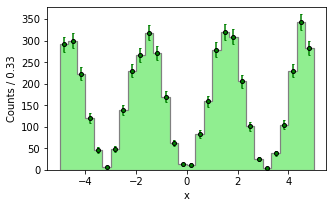

In [276]:
import numpy as np
import sympy as sp

def Accept_reject(f, xrange, yrange, N_accepted):
    '''Function for generating random numbers according to a given function
       using the accept/reject method.
       
       Input: f, xmin, xmax, ymin, ymax, N_accepted
       
       returns: 
       array of accepted values
       number of tries
       [efficiency, efficiency error]
       [integral, integral error]  
       [normalization, normalization error]'''

    x = sp.Symbol('x')
    f = sp.lambdify(x, f, 'numpy')
       
    r = np.random
    r.seed(42)
    
    N_try = 0
    x_accepted = []
    
    while len(x_accepted) < N_accepted:
        x = r.uniform(*xrange)
        y = r.uniform(*yrange)
        if y < f(x):
            x_accepted.append(x)
        N_try += 1


    eff = N_accepted / N_try 
    eff_err = np.sqrt(eff * (1-eff) / N_try)        # binomial error

    integral =  eff * (xrange[1]-xrange[0]) * (yrange[1]-yrange[0])
    integral_err = eff_err * (xrange[1]-xrange[0]) * (yrange[1]-yrange[0])

    normalization = 1 / integral
    normalization_err = integral_err / integral**2

    return x_accepted, N_try, [eff, eff_err], [integral, integral_err], [normalization, normalization_err]


#example the accept/reject function: 
data = Accept_reject('sin(x)**2', (-5,5), (0,1), 5000)
easy_hist(data[0], 30, Figsize=(5, 3));

In [91]:
# inverse transform method:

import sympy as sp
def inverse_transform(f,N, xmin, xmax=None):
    '''Function for generation random numbers according to the inverse transformation method using sympy.
    
       Input: f: function given as a string 
              N: number of point 
              xmin: lower limit of integration
              xmax: (optional) = infinity as default'''

    if xmax == None:
        xmax = sp.oo
    
    x, y = sp.symbols('x y')
    F_norm = sp.integrate(f, (x, xmin, xmax), conds='none')

    if F_norm == 0:
        print('ERROR: Integral is zero. Choose a different integration range.')
        return
    if F_norm == sp.oo:
        print('ERROR: Integral is diverging. Choose a different integration range.')
        return

    F = 1/F_norm * sp.integrate(f, (x, xmin, x), conds='none')
    F_inv = sp.solve(F-y, x)[0]
    F_inv = sp.lambdify(y, F_inv, 'numpy')
    r = np.random
    r.seed(42)
    y = r.uniform(0,1,N)
    x_values = F_inv(y)

    return x_values ,F_norm, F_inv

### Fisher Discriminant function: 

In [283]:
# fisher discriminant function:

import numpy as np

def fisher_discriminant(sample1, sample2, w0=True):
    """
    Calculates Fisher discriminants given two samples with the w0 correction term as default.
    
    Parameters:
        sample1 (numpy array): the first sample
        sample2 (numpy array): the second sample
        w0 (bool): if True, the w0 correction term is calculated
    
    Returns:
        (float): the calculated Fisher discriminant
    """
    mean1 = np.mean(sample1, axis=0)
    mean2 = np.mean(sample2, axis=0)
    cov1 = np.cov(sample1, rowvar=False)
    cov2 = np.cov(sample2, rowvar=False)
    cov_combined = cov1 + cov2
    inv_cov_combined = np.linalg.inv(cov_combined)

    wf = inv_cov_combined @ (mean1 - mean2)

    if w0:
        w0 = - np.sum(wf)

    fisher1 = sample1 @ wf + w0 
    fisher2 = sample2 @ wf + w0

    std_1 = np.std(sample1, ddof=1)
    std_2 = np.std(sample2, ddof=1)
    separation = np.abs((mean1 - mean2)) / np.sqrt(std_1**2 + std_2**2)
    
    # fisher_discriminant = np.dot((mean1 - mean2), np.dot(inv_cov_combined, (mean1 - mean2)))'

    return fisher1, fisher2, separation


In [284]:
x1 = gaussian_data(7, 2,500)
x2 = gaussian_data(3, 2,500)

fish1 , fish2, sep = fisher_discriminant(x1, x2)

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional